```
         Copyright Rein Halbersma 2020.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# The Relative Age Effect in Professional Football
 
## Re-implementing Marcel Wieting's [LinkedIn post](https://www.linkedin.com/pulse/web-scraping-relative-age-effect-professional-football-marcel-wieting/?trackingId=d8UqaacWy%2FaNdTYFhh4MsQ%3D%3D)


In [1]:
import calendar

import numpy as np
import pandas as pd
import plotnine as p9
from tqdm import tqdm

import scrape.transfermarkt as tm

## Fetching league URLs from the top EU leagues

In [2]:
eu_league_urls = list(filter(lambda link: link.endswith('1'), [
    tm.extract_league_link(league)
    for page in tqdm(range(1, 5))
    for league in tm.fetch_eu_leagues(page)
]))

100%|██████████| 4/4 [00:17<00:00,  4.31s/it]


## Fetching club URLs from all league URLs

In [3]:
eu_club_urls = [
    tm.extract_club_link(club)
    for league in tqdm(eu_league_urls)
    for club in tm.fetch_clubs(league)
]

100%|██████████| 51/51 [02:12<00:00,  2.60s/it]


## Fetching player data from all club URLs

In [4]:
eu_player_data = pd.concat([
    # Normally, we would extract player data from the team table with pd.read_html().
    # However, some cells contain nested HTML tables which would not have been handled gracefully.
    # Instead, we use tm.extract_player_data() on each player individually.
    pd.DataFrame(
        data=[
            tm.extract_player_data(player)
            for player in tm.fetch_players(club)
        ],
        columns=[
            'number', 'name', 'position', 'birth_date', 'market_value'
        ]
    ).assign(squad = club.split('/')[1])
    for club in tqdm(eu_club_urls)
])

100%|██████████| 701/701 [39:09<00:00,  3.35s/it]


## Tidying up the dataset

In [5]:
df = (eu_player_data
    .replace({'number': {'-': np.nan}})
    .astype(dtype={'number': float})
    .astype(dtype={'number': 'Int64'})
    .assign(birth_date = lambda r: pd.to_datetime(r.birth_date.str.split('(').str[0].replace('- ', ''), errors='coerce'))
    .dropna(subset=['birth_date'])
    .reset_index(drop=True)
    .assign(
        dayofyear    = lambda r: r.birth_date.dt.dayofyear.astype(int),
        month        = lambda r: r.birth_date.dt.month.astype(int),
        month_abbr   = lambda r: r.apply(lambda x: calendar.month_abbr[x.month], axis=1),
        weight       = lambda r: ((365 + r.birth_date.dt.is_leap_year) / 12) / r.birth_date.dt.days_in_month,
        market_value = lambda r: r.market_value.str.normalize('NFKD').str.replace(' ', '').replace('-', np.nan).str.replace('Th.', 'k'),
        multiplier   = lambda r: r.market_value.str[-1].replace('m', 1.).replace('k', .001)
    )
    .assign(market_value = lambda r: r.market_value.str[1:-1].replace('', np.nan).astype(float) * r.multiplier)
    .drop(columns=['multiplier'])
)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18722 entries, 0 to 18721
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   number        17213 non-null  Int64         
 1   name          18722 non-null  object        
 2   position      18722 non-null  object        
 3   birth_date    18722 non-null  datetime64[ns]
 4   market_value  16446 non-null  float64       
 5   squad         18722 non-null  object        
 6   dayofyear     18722 non-null  int64         
 7   month         18722 non-null  int64         
 8   month_abbr    18722 non-null  object        
 9   weight        18722 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 1.4+ MB


In [7]:
df.head()

,number,name,position,birth_date,market_value,squad,dayofyear,month,month_abbr,weight
0,1,Alisson,Goalkeeper,1992-10-02,72.0,fc-liverpool,276,10,Oct,0.983871
1,13,Adrián,Goalkeeper,1987-01-03,4.0,fc-liverpool,3,1,Jan,0.981183
2,62,Caoimhin Kelleher,Goalkeeper,1998-11-23,0.9,fc-liverpool,327,11,Nov,1.013889
3,4,Virgil van Dijk,Centre-Back,1991-07-08,80.0,fc-liverpool,189,7,Jul,0.981183
4,12,Joe Gomez,Centre-Back,1997-05-23,40.0,fc-liverpool,143,5,May,0.981183


In [8]:
df.tail()

,number,name,position,birth_date,market_value,squad,dayofyear,month,month_abbr,weight
18717,9,Christian Pacheco,Right Midfield,1998-11-19,NaN,fc-college-1975,323,11,Nov,1.013889
18718,8,Nacho Callejón,Attacking Midfield,1997-07-26,NaN,fc-college-1975,207,7,Jul,0.981183
18719,17,Alejandro Herrera,Attacking Midfield,1997-09-30,NaN,fc-college-1975,273,9,Sep,1.013889
18720,11,Yuri Ruh Dos Santos,Left Winger,1998-02-07,NaN,fc-college-1975,38,2,Feb,1.086310
18721,10,Juanfri,Centre-Forward,1998-05-01,NaN,fc-college-1975,121,5,May,0.981183


## Total players, by birth month (unweighted by length of month)

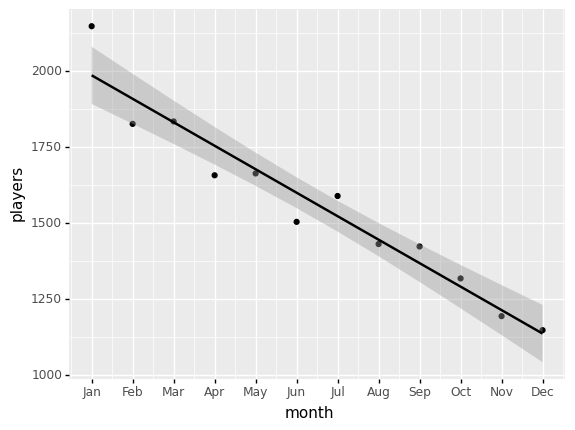

<ggplot: (8755242983933)>

In [9]:
data = (df
    .groupby(['month', 'month_abbr'])
    .agg(players = ('month', 'count'))
    .reset_index()
)
(p9.ggplot(data, p9.aes('month', 'players'))
    + p9.geom_point()
    + p9.stat_smooth(method='lm')
    + p9.scale_x_continuous(breaks=data.month, labels=data.month_abbr)
)

## Total players, by birth month (weighted by length of month)

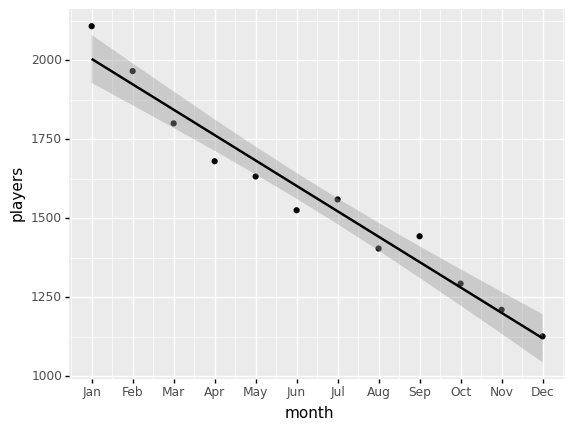

<ggplot: (8755241695793)>

In [10]:
data = (df
    .groupby(['month', 'month_abbr'])
    .agg(players = ('weight', 'sum'))
    .reset_index()
)
(p9.ggplot(data, p9.aes('month', 'players'))
    + p9.geom_point()
    + p9.stat_smooth(method='lm')
    + p9.scale_x_continuous(breaks=data.month, labels=data.month_abbr)
)

## Total players, by birthday

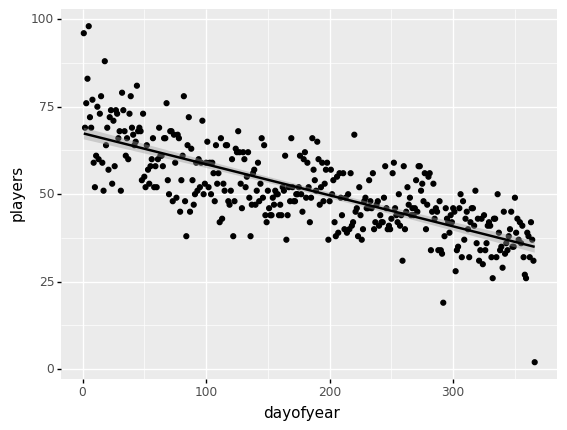

<ggplot: (8755241695796)>

In [11]:
data= (df
    .groupby('dayofyear')
    .agg(players = ('dayofyear', 'count'))
    .reset_index()
)
(p9.ggplot(data, p9.aes('dayofyear', 'players'))
    + p9.geom_point()
    + p9.stat_smooth(method='lm')
)